# Handwritten Digits (scikit-learn Digits Dataset)
- Difficulty: Intermediate
- Project Purpose: Classify digit “0” vs “1” (binary); stretch → expand to multinomial logistic regression (all digits).
- Points Examined: Binary logistic regression, multinomial logistic regression.
- Doc References: Multinomial logistic regression.
- Why Useful: Demonstrates extension from binary to multiclass.

# Part 0 Data download

In [1]:
!curl -L -o ./mnist-dataset.zip https://www.kaggle.com/api/v1/datasets/download/hojjatk/mnist-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0- --:--:--     0
100 22.0M  100 22.0M    0     0  6693k      0  0:00:03  0:00:03 --:--:-- 8127k


In [3]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [6]:
minst = fetch_openml('mnist_784', version=1, as_frame=False)

# Part 1 Preprocessing
Can't think of much at this stage despite train test split. Since there's no missing value, no need for over_sampling/under_sampling etc... StandardScaler will be included in the pipeline model.


In [41]:
X_train, X_test, y_train, y_test = train_test_split(minst['data'], minst['target'])

# Part 2 Hypothesis
Since we are using the basic regression model on top of this, which means we are using standard scaler + logistic regression. So behind the sense we are not capturing their relative positional information, like if there are some black line below the other black line, or say if blocked linked to each other they are a black line. Rather we are more just weighting different positional spot. Like if there's a vertical black line on the top, then it should be one of 5, 7. This will not be optimal but would work. And hypothesis is that there can be certain error when numbers partially share similar stuff.

In theory since numbers in terms of feature have some overlap, e.g. both 6 and 8 have circles in bottom, they do have overlap, and we assume that multinomial would do a better job.

For more information on multinomal vs ovr, I've checked this: https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html

In order to verify things above I would:
1. Compare ovr and multinomial
2. Construct confusion matrix to see which numbers usually get messed up together.

# Part 3 Training

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [11]:
ovr = make_pipeline(StandardScaler(), OneVsRestClassifier(LogisticRegression())) # again which solver is good for sparse feature?
mul = make_pipeline(StandardScaler(), LogisticRegression(multi_class='multinomial'))
ovr.fit(X_train, y_train)
mul.fit(X_train, y_train)

/Users/wujizhu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wujizhu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(multi_class='multinomial'))])

In [42]:
print(ovr.score(X_test, y_test))
print(mul.score(X_test, y_test))
from sklearn.metrics import classification_report
print(classification_report(y_test, ovr.predict(X_test), digits=4))
print(classification_report(y_test, mul.predict(X_test), digits=4))

0.9288571428571428
0.9371428571428572
              precision    recall  f1-score   support

           0     0.9652    0.9776    0.9714      1700
           1     0.9601    0.9734    0.9667      1952
           2     0.9244    0.9098    0.9170      1707
           3     0.9209    0.9064    0.9136      1785
           4     0.9228    0.9432    0.9329      1761
           5     0.9040    0.8952    0.8996      1546
           6     0.9484    0.9557    0.9520      1693
           7     0.9389    0.9409    0.9399      1812
           8     0.8912    0.8816    0.8864      1765
           9     0.9064    0.8983    0.9023      1779

    accuracy                         0.9289     17500
   macro avg     0.9282    0.9282    0.9282     17500
weighted avg     0.9287    0.9289    0.9287     17500

              precision    recall  f1-score   support

           0     0.9758    0.9741    0.9750      1700
           1     0.9625    0.9734    0.9679      1952
           2     0.9294    0.9250    0.9

In [15]:
# Wow??? Didn't expect things to go this well??
# The score here shows that there's almost indifference between two models. While OvR is a bit higher than Multinomial, I would argue that is just variance/lucky split.
# Here's my justification for why they perform similar (why ovr is even a bit better)
# we see that the test score is pretty high, which means that the dataset, in terms of logistic regression, is actually pretty separated from the space against each other, and this is not an overfit (I know there are 728 features) as test scores are still high
# Under this case, we know that class didn't overlap with each other, so ovr ~ multinomial

# Part 4 Construct Confusion Matrix to see which number easily mess up with other

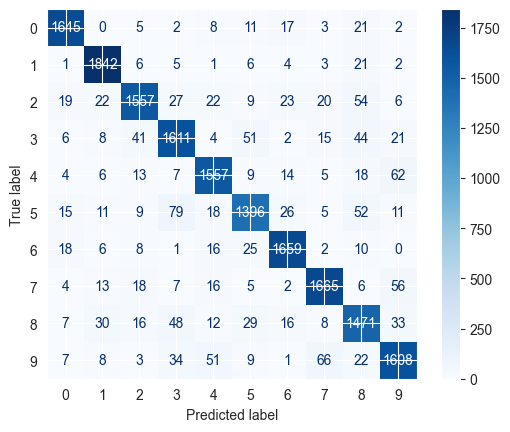

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = ovr.predict(X_test)
cls = mul.classes_
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls)
disp.plot(cmap='Blues')
plt.show()

The finding here is pretty intuitive:
- We see that 8 get miss classified to many other numbers, this make sense, as we can find many number within 8
- 6 and 5 also get miss classified against each other a bit, which also make sense as they look similar to each other.
- ...

# Part 5 Play around with Logistic Regression OvR vs Multinomial
Here will follow what example here does: https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html to generate 3 cluster 2d points. Will check the performance difference for OvR vs Multinomial as we increase variance (more overlap).

Accuracy score: Multinomial 1.0, OvR: 0.98
Accuracy score: Multinomial 0.95, OvR: 0.9266666666666666
Accuracy score: Multinomial 0.8866666666666667, OvR: 0.8533333333333334
Accuracy score: Multinomial 0.8233333333333334, OvR: 0.7966666666666666
Accuracy score: Multinomial 0.76, OvR: 0.7566666666666667


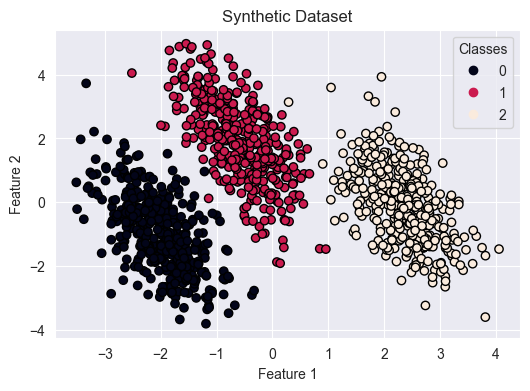

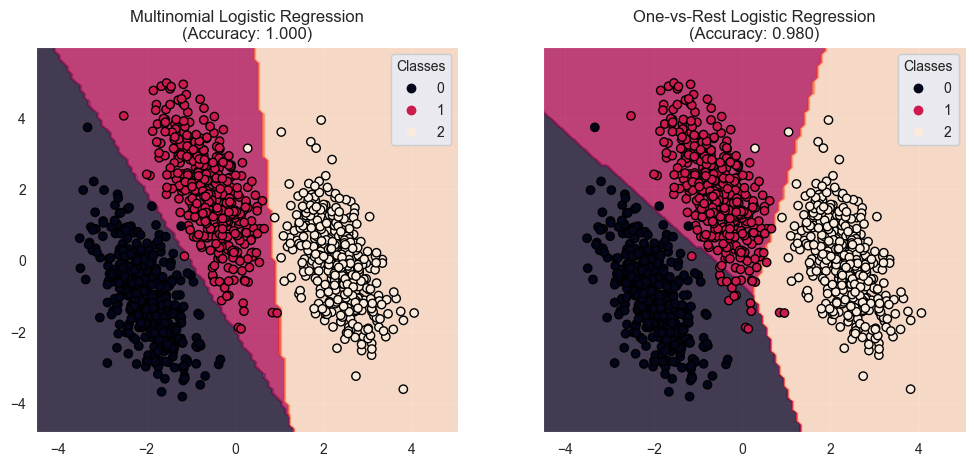

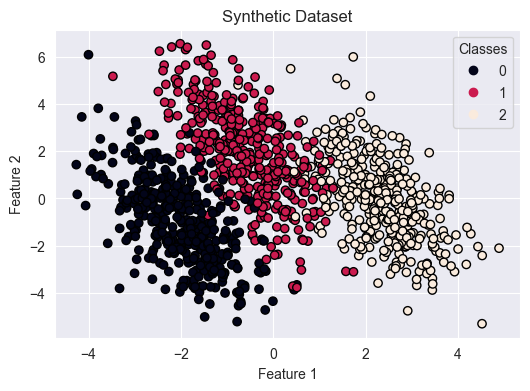

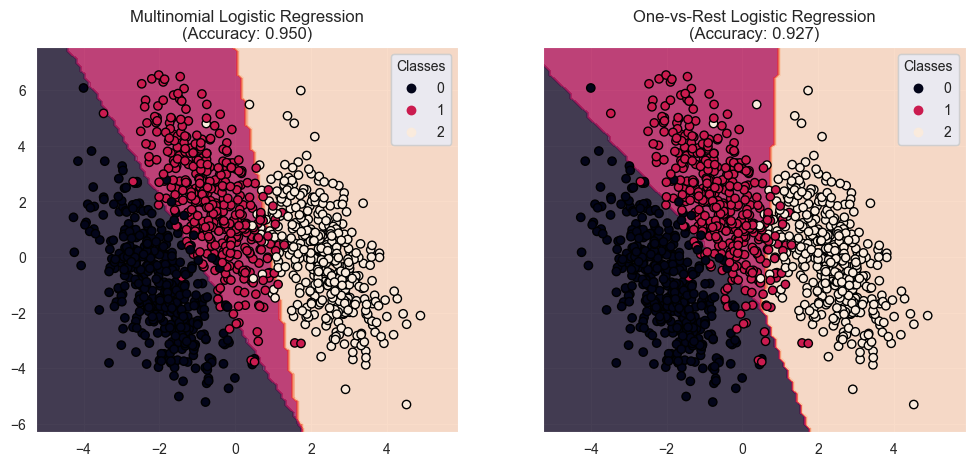

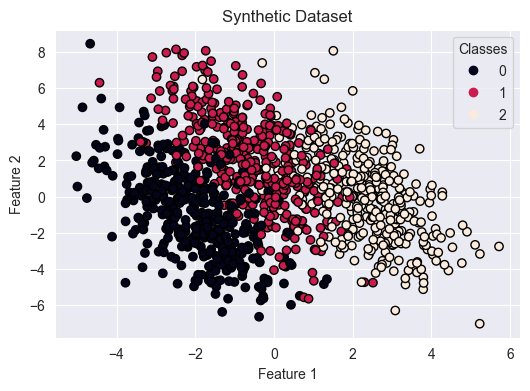

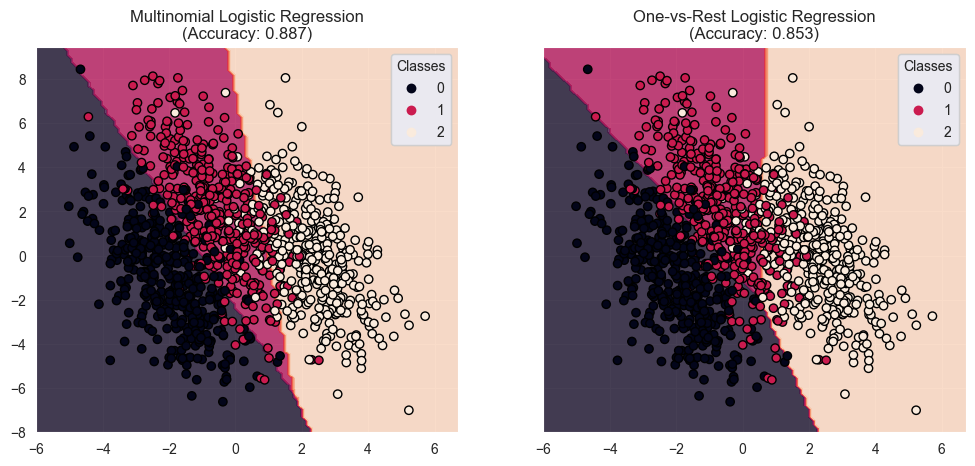

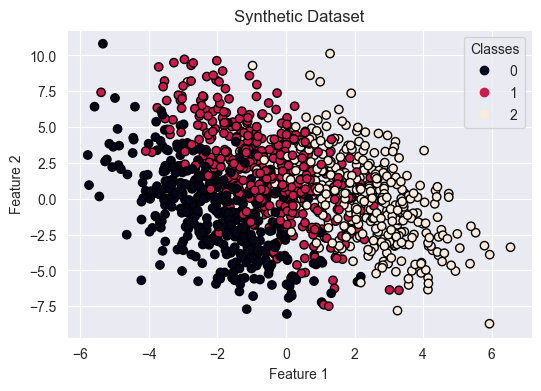

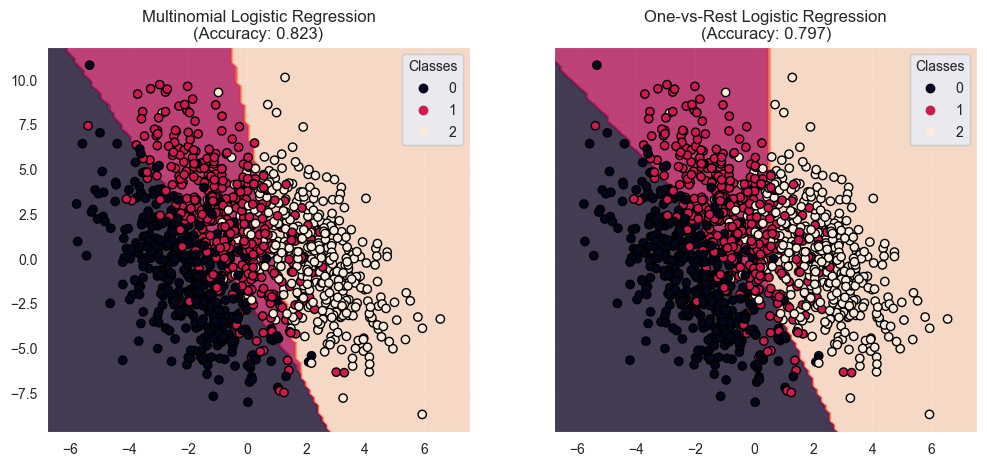

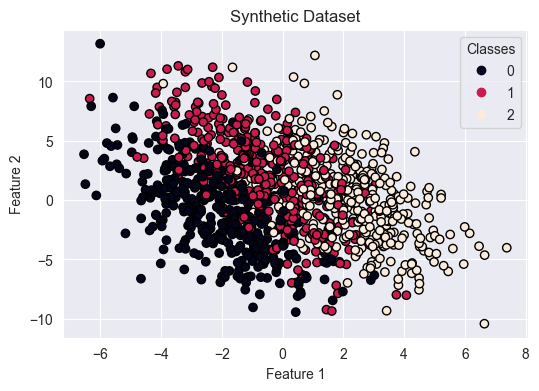

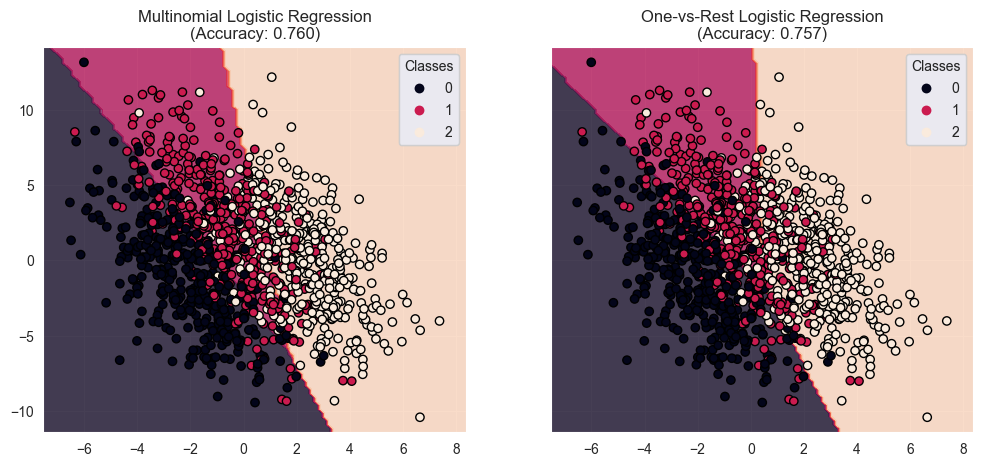

In [40]:
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay
centers = [[-5, 0], [0, 1.5], [5, -1]]
for std in [1.0, 1.5, 2.0, 2.5, 3.0]:
    X, y = make_blobs(n_samples=1200, n_features=2, centers=centers, random_state=42, cluster_std=std)
    transformation = [[0.4, 0.2], [-0.4, 1.2]]
    X = np.dot(X, transformation)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    fig, ax = plt.subplots(figsize=(6, 4))
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="black")
    ax.set(title="Synthetic Dataset", xlabel="Feature 1", ylabel="Feature 2")
    _ = ax.legend(*scatter.legend_elements(), title="Classes")
    logistic_regression_multinomial = LogisticRegression().fit(X_train, y_train)
    logistic_regression_ovr = OneVsRestClassifier(LogisticRegression()).fit(X_train, y_train)
    accuracy_multinomial = logistic_regression_multinomial.score(X_test, y_test)
    accuracy_ovr = logistic_regression_ovr.score(X_test, y_test)
    print(f"Accuracy score: Multinomial {accuracy_multinomial}, OvR: {accuracy_ovr}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    for model, title, ax in [
        (
            logistic_regression_multinomial,
            f"Multinomial Logistic Regression\n(Accuracy: {accuracy_multinomial:.3f})",
            ax1,
        ),
        (
            logistic_regression_ovr,
            f"One-vs-Rest Logistic Regression\n(Accuracy: {accuracy_ovr:.3f})",
            ax2,
        )]:
        DecisionBoundaryDisplay.from_estimator(
            model,
            X,
            ax=ax,
            response_method="predict",
            alpha=0.8,
        )
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
        legend = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend)
        ax.set_title(title)


In [27]:
# we see that multinomial usually did bit better when clusters do overlap with each other, but only to a limited amount

[[ 2.61842661 -0.19274717]
 [-2.21200206 -1.53889836]
 [-1.35690294  1.38442911]
 [-2.1174061  -1.31862562]
 [ 1.69529349  0.54956519]
 [-1.18264458 -2.3005034 ]
 [-0.46720148  1.76217498]
 [ 2.03508863 -0.05730051]
 [-1.32342997 -0.97780181]
 [-1.79828815 -2.87636926]
 [-2.00000657 -1.32779502]
 [ 2.17980302  0.84795806]
 [-0.74975638  1.26639481]
 [ 1.98496698 -0.19230136]
 [ 2.60333922 -1.15356102]
 [ 2.62023808  0.48801234]
 [-2.51543932 -0.40137285]
 [ 3.21775261 -1.51433374]
 [ 2.37051834 -1.35687523]
 [-0.82613463  2.25260389]
 [-0.83071378  2.18460071]
 [ 1.41225654  1.47603644]
 [ 2.88047161 -1.55992261]
 [-0.76969544  0.92233546]
 [ 1.97010687  2.24056361]
 [-1.74600862 -1.06657433]
 [-0.94862698  2.9817895 ]
 [-1.40308944 -2.69619218]
 [ 1.8788345   0.73837556]
 [-2.30347111 -2.15951745]
 [-1.21435846  2.15585017]
 [-1.77316068 -0.64666475]
 [-2.43021721  0.18983745]
 [ 2.99312996 -1.1034556 ]
 [-1.96011224  0.32373605]
 [-1.97665904  2.26233398]
 [ 2.31514542  0.29701704]
 

# GPT's review
1. Stratification on split
I didn’t see stratify=y in train_test_split. MNIST is fairly balanced, but stratifying is best practice to keep label proportions aligned.
2. Convergence control (solver + iterations)
You’re using multinomial once but didn’t pin an explicit solver or max_iter. Defaults may converge slowly/silently under-iterate on 70k×784.
3. Metrics beyond accuracy
I saw confusion_matrix=True but no classification_report, ROC/PR (one-vs-rest micro/macro), or per-class F1. For multiclass, **macro-F1** highlights minority trouble even when accuracy looks great.
4. OvR vs Multinomial: make the comparison fair
You compared the two, great—but ensure identical preprocessing, same C, same split, and same max_iter. Wrap both in identical Pipelines and print a small table.

Snippet:
```
base = lambda multi: make_pipeline(
    StandardScaler(),
    LogisticRegression(multi_class=multi, solver="lbfgs", max_iter=300, n_jobs=-1)
)
ovr = base("ovr").fit(X_train, y_train)
mul = base("multinomial").fit(X_train, y_train)
```
5. Error analysis
You’ve got the confusion matrix; go one step further: show the top misclassifications (e.g., 5↔3, 9↔4). This is where multinomial often helps in overlapping classes.
```
import numpy as np
y_pred = mul.predict(X_test)
wrong = np.where(y_pred != y_test)[0]
# show a few
import matplotlib.pyplot as plt
for i in wrong[:12]:
    plt.figure()
    plt.imshow(X_test[i].reshape(28,28), cmap="gray")
    plt.title(f"true={y_test[i]} pred={y_pred[i]}")
    plt.axis("off")
    plt.show()
```
6. What is C in logistic regression?
In scikit-learn, C is the inverse of regularization strength.
Formula-wise:
Logistic regression minimizes loss + (1/2C) * ||weights||² (for L2 regularization).

Intuition:
Smaller C → stronger regularization (weights are forced smaller → simpler decision boundaries, less overfitting).
Larger C → weaker regularization (model fits training data more tightly, but may overfit).

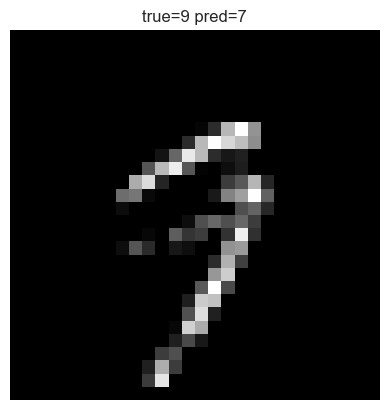

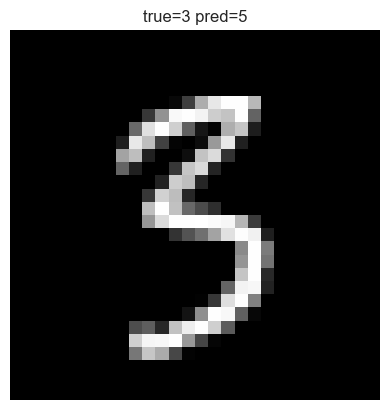

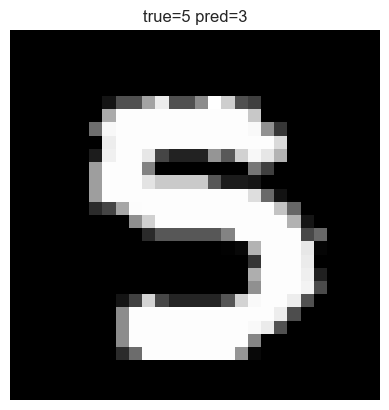

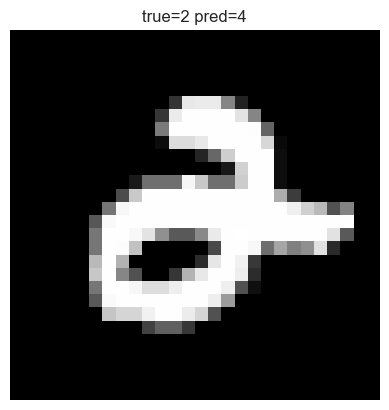

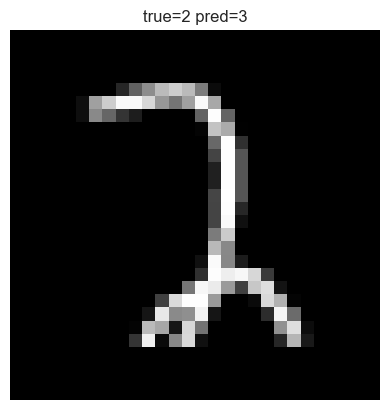

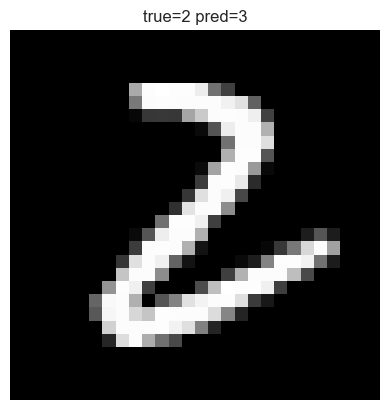

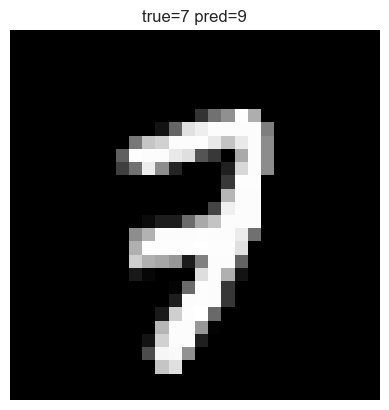

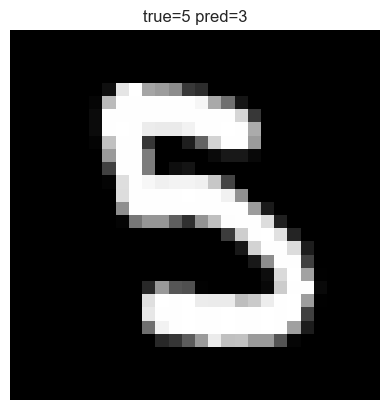

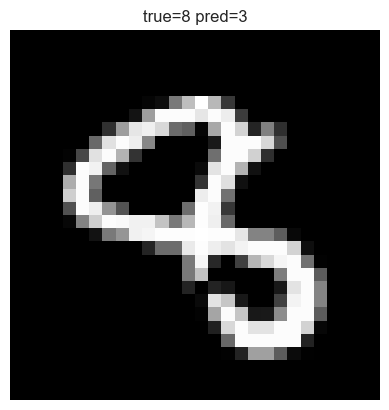

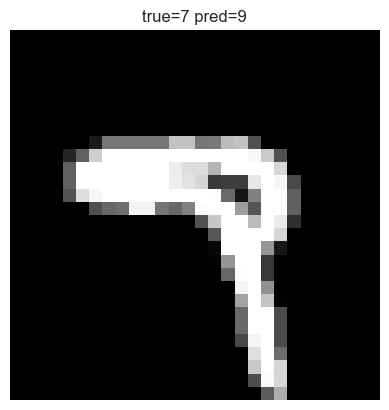

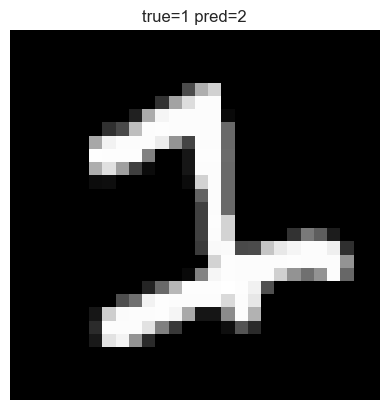

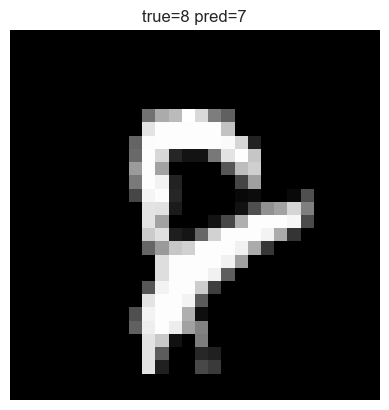

In [43]:
import numpy as np
y_pred = mul.predict(X_test)
wrong = np.where(y_pred != y_test)[0]
# show a few
import matplotlib.pyplot as plt
for i in wrong[:12]:
    plt.figure()
    plt.imshow(X_test[i].reshape(28,28), cmap="gray")
    plt.title(f"true={y_test[i]} pred={y_pred[i]}")
    plt.axis("off")
    plt.show()

In [44]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, accuracy_score, f1_score

Cs = [0.1, 0.5, 1, 2, 5, 10]
pipe_cv = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(
        Cs=Cs, cv=3, multi_class="multinomial",
        solver="lbfgs", max_iter=400, n_jobs=-1
    )
)
pipe_cv.fit(X_train, y_train)

y_pred = pipe_cv.predict(X_test)
print("Best C:", pipe_cv.named_steps["logisticregressioncv"].C_[0])
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

Best C: 0.1
Accuracy: 0.9192
Macro F1: 0.9184334611796204

Classification report:
               precision    recall  f1-score   support

           0     0.9626    0.9541    0.9583      1700
           1     0.9508    0.9708    0.9607      1952
           2     0.9031    0.9063    0.9047      1707
           3     0.9072    0.8924    0.8997      1785
           4     0.9176    0.9233    0.9205      1761
           5     0.8771    0.8862    0.8816      1546
           6     0.9407    0.9462    0.9435      1693
           7     0.9379    0.9255    0.9317      1812
           8     0.8921    0.8714    0.8816      1765
           9     0.8958    0.9084    0.9020      1779

    accuracy                         0.9192     17500
   macro avg     0.9185    0.9185    0.9184     17500
weighted avg     0.9192    0.9192    0.9191     17500



Why C=0.1 helps here

Remember: small C → stronger regularization (simpler model, smaller weights).

MNIST digits are pretty well-defined and high-dimensional (784 pixels per image).

Without regularization (big C), the model might overfit to subtle quirks in the training set (tiny pixel-level noise, stroke thickness, etc.).

With stronger regularization (C=0.1), the model smooths out those quirks and generalizes better.

So in this case:

It’s not that digits have “no outliers” — they do (messy handwriting, thick/thin strokes).

But the model benefits from ignoring those outliers and focusing on the broad strokes (pun intended 😅).